<a href="https://colab.research.google.com/github/nargesalavi/QAOA-for-MAXCUT/blob/main/qaoa_maxcut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit

In [29]:
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

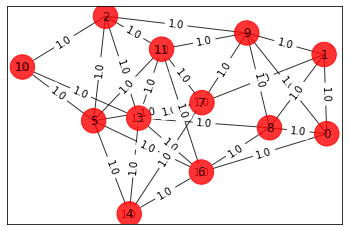

In [30]:
# Generating a graph of 4 nodes

n=12 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist = []
#elist=[(1,0,1.0),(1,2,1.0),(1,3,1.0),(1,4,1.0),(1,5,1.0),(1,6,1.0),(1,7,1.0),(1,8,1.0),(1,9,1.0),(1,10,1.0),(1,11,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
for i in range (0,n):
    for j in range(i,n):
        if np.random.random() < 0.5:
            continue
        else:
            elist.append((i,j,1.0))

G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [31]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)

[[0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1.]
 [0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1.]
 [1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1.]
 [0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.]]



Best solution = [0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0] cost = 23.0


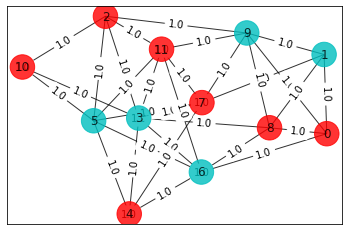

In [32]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

In [33]:
qubitOp, offset = max_cut.get_operator(w)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

Offset: -15.5
Ising Hamiltonian:
IIIIIIIIIIZZ	(0.5+0j)
IIIIIIIIZZII	(0.5+0j)
IIIIIIIZZIII	(0.5+0j)
IIIIIIZIIZII	(0.5+0j)
IIIIIIZZIIII	(0.5+0j)
IIIIIZIIIIIZ	(0.5+0j)
IIIIIZIIZIII	(0.5+0j)
IIIIIZIZIIII	(0.5+0j)
IIIIIZZIIIII	(0.5+0j)
IIIIZIIIIIZI	(0.5+0j)
IIIIZIIIZIII	(0.5+0j)
IIIIZIIZIIII	(0.5+0j)
IIIIZIZIIIII	(0.5+0j)
IIIZIIIIIIIZ	(0.5+0j)
IIIZIIIIIIZI	(0.5+0j)
IIIZIIIIZIII	(0.5+0j)
IIIZIZIIIIII	(0.5+0j)
IIZIIIIIIIIZ	(0.5+0j)
IIZIIIIIIIZI	(0.5+0j)
IIZIIIIIIZII	(0.5+0j)
IIZIZIIIIIII	(0.5+0j)
IIZZIIIIIIII	(0.5+0j)
IZIIIIIIIZII	(0.5+0j)
IZIIIIIIZIII	(0.5+0j)
IZIIIIZIIIII	(0.5+0j)
ZIIIIIIIIZII	(0.5+0j)
ZIIIIIIIZIII	(0.5+0j)
ZIIIIIZIIIII	(0.5+0j)
ZIIIIZIIIIII	(0.5+0j)
ZIIIZIIIIIII	(0.5+0j)
ZIZIIIIIIIII	(0.5+0j)



In [34]:
# mapping Ising Hamiltonian to Quadratic Program
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;
dvar bool x_5;
dvar bool x_6;
dvar bool x_7;
dvar bool x_8;
dvar bool x_9;
dvar bool x_10;
dvar bool x_11;

minimize
 [ - 4 x_0^2 + 2 x_0*x_1 + 2 x_0*x_6 + 2 x_0*x_8 + 2 x_0*x_9 - 4 x_1^2
 + 2 x_1*x_7 + 2 x_1*x_8 + 2 x_1*x_9 - 5 x_2^2 + 2 x_2*x_3 + 2 x_2*x_5
 + 2 x_2*x_9 + 2 x_2*x_10 + 2 x_2*x_11 - 7 x_3^2 + 2 x_3*x_4 + 2 x_3*x_6
 + 2 x_3*x_7 + 2 x_3*x_8 + 2 x_3*x_10 + 2 x_3*x_11 - 4 x_4^2 + 2 x_4*x_5
 + 2 x_4*x_6 + 2 x_4*x_7 - 6 x_5^2 + 2 x_5*x_6 + 2 x_5*x_7 + 2 x_5*x_10
 + 2 x_5*x_11 - 6 x_6^2 + 2 x_6*x_8 + 2 x_6*x_11 - 6 x_7^2 + 2 x_7*x_9
 + 2 x_7*x_11 - 5 x_8^2 + 2 x_8*x_9 - 6 x_9^2 + 2 x_9*x_11 - 3 x_10^2
 - 6 x_11^2 ];
 
subject to {

}


In [35]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

optimal function value: -23.0
optimal value: [0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0.]
status: SUCCESS


energy: -7.5
max-cut objective: -23.0
solution: [1 0 1 0 1 0 0 1 1 0 1 1]
solution objective: 23.0


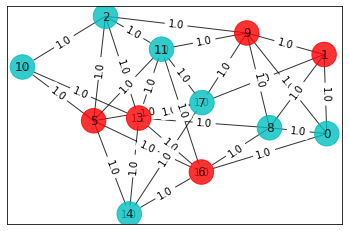

In [37]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

In [ ]:
display(HTML('<h1>Plot histogram</h1>'))

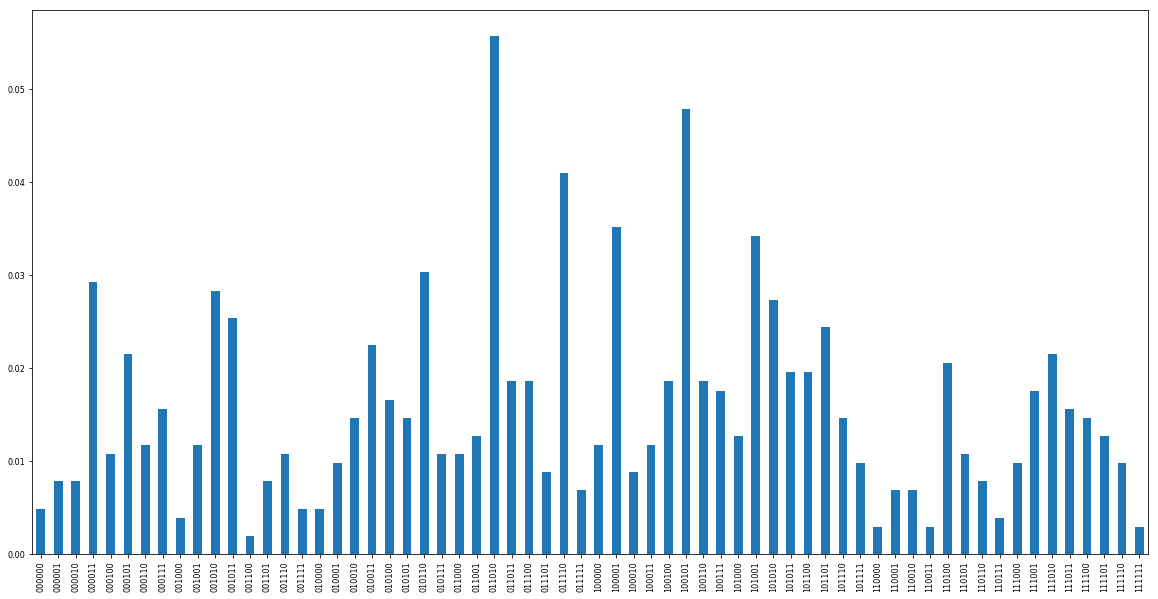

In [ ]:
df = pd.DataFrame.from_dict(result['min_vector'], orient='index') / n_shots
df = df.sort_index()
barplot = df.plot.bar(legend=False, figsize=(20, 10), fontsize=8)
plt.show()